#### Importing Airbnb dataset

In [1]:
import pandas as pd
import os
import math
import seaborn as sns
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from skforecast.model_selection import grid_search_forecaster
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

sns.set_style("whitegrid")

In [2]:
# import airbnb datasets
listings = pd.read_csv("listings.csv")
listings.dropna(axis=1)
listings.columns


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [3]:
# Dropping useless columns
listings = listings[['id', 'name','host_since',
       'host_response_time', 'host_response_rate',
       'host_is_superhost','host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']]

listings.shape

(9020, 56)

In [4]:
# all text columns to lowercase

def lowercase_strings(value):
    return value.lower() if isinstance(value, str) else value

listings = listings.applymap(lowercase_strings)

#### Read files in folder for sensor data

In [5]:
# Function for reading csv files in folder

def read_csv_files_in_folder(folder_path):    
    # Get a list of all files in the folder
    file_list = [file for file in os.listdir(folder_path) if file.lower().endswith('.csv')]

    # Check  CSV files in the folder
    if not file_list:
        raise ValueError(f"No CSV files found in the folder '{folder_path}'.")

    # Read and concatenate the CSV files
    dfs = []
    for file in file_list:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        
        # Add a 'sensor' column with the name of the file
        df['sensor'] = os.path.splitext(file)[0]
        
        dfs.append(df)

    concatenated_df = pd.concat(dfs, ignore_index=True)

    return concatenated_df

In [6]:
Noise = read_csv_files_in_folder("C:\\Users\\santi\\OneDrive\\Desktop\\Flags\\Capstone\\Noise sensors")

In [7]:
Noise

,Date and Time,LAeq,sensor
0,2023-11-15 01:00:00,58.3,Ballymun
1,2023-11-15 02:00:00,57.8,Ballymun
2,2023-11-15 03:00:00,54.1,Ballymun
3,2023-11-15 04:00:00,55.0,Ballymun
4,2023-11-15 05:00:00,56.7,Ballymun
...,...,...,...
10397,2023-12-15 19:00:00,47.6,Woodstock gardens
10398,2023-12-15 20:00:00,46.3,Woodstock gardens
10399,2023-12-15 21:00:00,45.2,Woodstock gardens
10400,2023-12-15 22:00:00,45.6,Woodstock gardens


In [8]:
# Apply function to air quality as well
Air = read_csv_files_in_folder("C:\\Users\\santi\\OneDrive\\Desktop\\Flags\\Capstone\\Air sensors")

In [9]:
#Keeping only not NAN columns
Air = Air.dropna(axis=1)
Air

,Date and Time,PM<sub>10</sub>,PM<sub>2.5</sub>,sensor
0,2023-11-15 00:00:00,27.64,17.56,Ballyfermot
1,2023-11-16 00:00:00,25.57,17.41,Ballyfermot
2,2023-11-17 00:00:00,14.13,7.06,Ballyfermot
3,2023-11-18 00:00:00,8.86,5.68,Ballyfermot
4,2023-11-19 00:00:00,7.95,5.01,Ballyfermot
...,...,...,...,...
548,2023-12-11 00:00:00,7.50,6.52,Walkinstown library
549,2023-12-12 00:00:00,8.17,7.06,Walkinstown library
550,2023-12-13 00:00:00,5.34,3.80,Walkinstown library
551,2023-12-14 00:00:00,16.85,14.46,Walkinstown library


#### calculate attributes for sensors

In [10]:
Attributes_by_Sensor = Noise.groupby('sensor')['LAeq'].agg(['mean',
                                                            'max',
                                                            'min',
                                                            'var',
                                                            lambda x: (x > 60).sum(),
                                                            lambda x: (x > 70).sum(),
                                                            lambda x: (x > 80).sum()
                                                            ] )
Attributes_by_Sensor.columns = ['mean Noise',	'max Noise',	'min Noise',	'var Noise'	,'more 60 Noise',	'more 70 Noise'	,'more 80 Noise']

In [11]:
Noise['Date and Time'] = pd.to_datetime(Noise['Date and Time'])
Noise['Day name'] = Noise['Date and Time'].dt.day_name()

weekend = Noise[(Noise['Day name'] == 'Friday') | (Noise['Day name'] == 'Saturday') | (Noise['Day name'] == 'Sunday')]
weekend = weekend.groupby('sensor')['LAeq'].agg(['mean', 'max','min','var'])

new_column_names = {'mean weekend': 'max weekend', 'min weekend': 'var weekend'}

# Rename columns
weekend.columns = ['mean weekend Noise', 'max weekend Noise', 'min weekend Noise', 'var weekend Noise']

Attributes_by_Sensor = pd.merge(weekend, Attributes_by_Sensor, on='sensor')

In [12]:
#Check dataset of air quality
Attributes_by_Sensor_air = Air.groupby('sensor')[['PM<sub>10</sub>','PM<sub>2.5</sub>']].agg(['mean', 'max','min','var'])
Attributes_by_Sensor_air

PM<sub>10</sub>                          \
                                   mean    max   min        var   
sensor                                                            
Ballyfermot                   13.994516  27.64  3.68  47.585086   
Cabra community college        7.765806  18.69  2.70  13.989438   
Coolock                        8.952258  16.39  2.96  15.532378   
Custom house quay             13.267419  24.80  5.09  26.376166   
Davitt Road                   14.969032  29.44  3.34  63.549249   
Donnybrook fire station       10.396129  25.30  4.13  20.435691   
Dublin port                   20.784194  41.69  6.19  78.362492   
Finglas                       12.082903  27.08  3.97  34.877641   
Lord edward street             8.799677  18.30  3.43  14.190763   
Marino                        14.870323  35.17  4.98  48.611163   
Mount joy square              14.328710  29.85  4.52  42.452198   
Phoenix park                  10.280323  22.18  3.48  18.340550   
Rathmines                     15.963548  36.96  4.99  69.194004   
Ringsend                      15.158065  39.24  4.96  57.929783   
ST johns road west            15.092903  34.34  5.11  47.462008   
Sandynount green              16.050645  27.78  8.05  35.144273   
St anne's park                11.971290  22.05  4.19  23.831618   
Walkinstown library            8.114231  16.85  3.10  16.415977   

                        PM<sub>2.5</sub>                          
                                    mean    max   min        var  
sensor                                                            
Ballyfermot                     9.484839  22.11  2.48  32.097186  
Cabra community college         5.895484  12.55  2.00   8.913646  
Coolock                         7.340645  14.13  2.37  12.241040  
Custom house quay               8.881935  16.48  3.17  12.181049  
Davitt Road                     9.554194  23.10  2.30  36.068332  
Donnybrook fire station         7.457419  13.94  2.63   7.545173  
Dublin port                    10.702258  23.78  4.36  27.482978  
Finglas                         8.178065  20.59  2.60  22.297749  
Lord edward street              6.811613  13.42  2.60   9.498654  
Marino                         10.027419  28.01  3.12  34.262880  
Mount joy square                9.379355  22.24  2.41  27.868866  
Phoenix park                    6.601613  16.22  2.17  11.435394  
Rathmines                      11.029677  28.91  2.82  54.761623  
Ringsend                        8.138065  18.79  2.42  16.499936  
ST johns road west              9.565806  24.99  3.04  30.666072  
Sandynount green               12.836129  20.06  7.08  12.284045  
St anne's park                  7.789677  18.70  2.52  16.573843  
Walkinstown library             6.728462  14.46  2.43  13.641022

#### Locations of Sensors 

In [13]:
#Coordinates of Air quality sensors in CSV
Locations_Air = pd.read_csv("C:\\Users\\santi\\OneDrive\\Desktop\\Flags\\Capstone\\locations air.csv")
Air_sensors = pd.merge(Attributes_by_Sensor_air, Locations_Air, on='sensor')

C:\Users\santi\AppData\Local\Temp\ipykernel_27572\34320944.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  Air_sensors = pd.merge(Attributes_by_Sensor_air, Locations_Air, on='sensor')


In [14]:
#Coordinates of Noise sensors
Locations_Noise = pd.DataFrame({
    'sensor': ['Ballymun', 'Bellyfermot civic center', 'Blessington basin', 'Chancery park', 'DCC Rowing club',
               'Dolphins barn', 'Drumcondra_library', 'Mellow park', 'Navan road', 'Raheny', 'Ringsend sport centre',
               'Strand road', 'Walkinstown', 'Woodstock gardens'],
    'latitude': [53.390919, 53.343215, 53.357244, 53.34652902870364, 53.346158, 53.331141895990676, 53.36989148853905,
                 53.390391, 53.370806, 53.380108, 53.340236666389245, 53.32797988955187, 53.319599730384574, 53.32354934764496],
    'longitude': [-6.265741, -6.362101, -6.271011, -6.27222408906346, -6.320942, -6.292304521951303, -6.259054548664786,
                  -6.303545, -6.325517, -6.172811, -6.219788026210866, -6.208968500024523, -6.3221433578079855, -6.24769455032394]
})


#### Join attributes and locations for sensors

In [15]:
#Merge attributes of sensor and locaiton of sensor using name of sensor
Noise_sensors = pd.merge(Attributes_by_Sensor, Locations_Noise, on='sensor')
Noise_sensors

,sensor,mean weekend Noise,max weekend Noise,min weekend Noise,var weekend Noise,mean Noise,max Noise,min Noise,var Noise,more 60 Noise,more 70 Noise,more 80 Noise,latitude,longitude
0,Ballymun,64.661538,72.7,56.6,10.044432,64.811709,74.8,54.1,14.408124,630,12,0,53.390919,-6.265741
1,Bellyfermot civic center,57.000321,67.2,48.4,12.645498,57.223149,80.8,46.1,18.927442,134,9,1,53.343215,-6.362101
2,Blessington basin,62.402564,86.9,42.0,107.924109,62.089367,92.0,39.9,120.772784,349,169,79,53.357244,-6.271011
3,Chancery park,60.970833,74.8,54.6,8.380851,61.140242,74.8,52.2,10.000360,505,9,0,53.346529,-6.272224
4,DCC Rowing club,55.393590,66.8,45.4,13.228448,54.900673,66.8,42.9,16.308854,35,0,0,53.346158,-6.320942
5,Dolphins barn,57.383013,71.4,47.5,14.295498,57.389367,71.4,45.9,16.613027,205,2,0,53.331142,-6.292305
6,Drumcondra_library,38.790064,48.1,32.7,8.350930,39.178466,56.9,31.9,11.401342,0,0,0,53.369891,-6.259055
7,Mellow park,56.622115,77.8,48.3,15.361085,56.959892,77.8,47.1,17.236206,146,4,0,53.390391,-6.303545
8,Navan road,55.289103,62.3,49.8,6.229334,55.021265,79.2,46.4,12.332270,29,7,0,53.370806,-6.325517
9,Raheny,54.962500,75.0,45.3,12.273412,54.969448,75.0,42.6,17.767677,35,4,0,53.380108,-6.172811


#### Function for calculate distance of each listing with sensor and assign listing to neirest sensor

In [16]:
#Noise sensors

#For each listing
for l_index, lis in listings.iterrows():
    lx = lis['latitude']
    ly = lis['longitude']

    #compare new closeness to old closeness (start very high at 10000)
    closeness = 100000
    closest_sensor_name = None

    for index, row in Noise_sensors.iterrows():
        nx = row['latitude']
        ny = row['longitude']
        name = row['sensor']
        
        # calculate distance from listing to sensor
        distance = math.sqrt((lx - nx)**2 + (ly - ny)**2)

        # if distance smaller than previous one, keep new one
        if distance < closeness:
            closeness = distance
            closest_sensor_name = name

    # add name of closest sensor to listing which will be use later as join key for adding attributes (mean,min,max ...)
    listings.at[l_index, 'sensor Noise'] = closest_sensor_name
    
    
# sane thing for air quality sensors
for l_index, lis in listings.iterrows():
    lx = lis['latitude']
    ly = lis['longitude']

    closeness = 100000
    closest_sensor_name = None

    for index, row in Air_sensors.iterrows():
        nx = row['latitude']
        ny = row['longitude']
        name = row['sensor']

        distance = math.sqrt((lx - nx)**2 + (ly - ny)**2)

        if distance < closeness:
            closeness = distance
            closest_sensor_name = name

    listings.at[l_index, 'sensor Air'] = closest_sensor_name

        



#### Merge sensor data to listings

In [17]:
#merge listings with noise and air quality
listings = pd.merge(listings, Noise_sensors, left_on='sensor Noise',right_on='sensor')
listings = pd.merge(listings, Air_sensors, left_on='sensor Air',right_on='sensor')

In [18]:
# keep columns with more than 1 value and rows which have price not null
listings = listings[listings['price'].notnull()]
selected_columns = listings.columns[listings.nunique() > 1]
listings = listings[selected_columns]
listings.shape

(5227, 78)

Data cleaning and transformation

In [19]:
listings.shape

(5227, 78)

In [20]:
#cjeck unique values
for x in listings.columns:
    print(x , " / unique: ", listings[x].nunique())

id  / unique:  5227
name  / unique:  4104
host_since  / unique:  2111
host_response_time  / unique:  4
host_response_rate  / unique:  54
host_is_superhost  / unique:  2
host_listings_count  / unique:  43
host_total_listings_count  / unique:  60
host_verifications  / unique:  6
host_has_profile_pic  / unique:  2
host_identity_verified  / unique:  2
latitude_x  / unique:  4605
longitude_x  / unique:  4766
property_type  / unique:  56
room_type  / unique:  4
accommodates  / unique:  16
bathrooms_text  / unique:  28
beds  / unique:  20
price  / unique:  523
minimum_nights  / unique:  53
maximum_nights  / unique:  109
minimum_minimum_nights  / unique:  51
maximum_minimum_nights  / unique:  57
minimum_maximum_nights  / unique:  100
maximum_maximum_nights  / unique:  102
minimum_nights_avg_ntm  / unique:  211
maximum_nights_avg_ntm  / unique:  269
has_availability  / unique:  2
availability_30  / unique:  31
availability_60  / unique:  61
availability_90  / unique:  91
availability_365  / uni

In [21]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5227 entries, 3 to 9019
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5227 non-null   int64  
 1   name                                          5227 non-null   object 
 2   host_since                                    5222 non-null   object 
 3   host_response_time                            4522 non-null   object 
 4   host_response_rate                            4522 non-null   object 
 5   host_is_superhost                             5213 non-null   object 
 6   host_listings_count                           5222 non-null   float64
 7   host_total_listings_count                     5222 non-null   float64
 8   host_verifications                            5227 non-null   object 
 9   host_has_profile_pic                          5222 non-null   o

In [22]:
#check one row randomly and print all features
for column, value in listings.iloc[2000].items():
    print(f"{column}: {value}\n   ------------- ")

id: 15771766
   ------------- 
name: home in sutton · ★4.85 · 1 bedroom · 2 beds · 1 private bath
   ------------- 
host_since: 2016-09-04
   ------------- 
host_response_time: within an hour
   ------------- 
host_response_rate: 100%
   ------------- 
host_is_superhost: t
   ------------- 
host_listings_count: 4.0
   ------------- 
host_total_listings_count: 5.0
   ------------- 
host_verifications: ['email', 'phone']
   ------------- 
host_has_profile_pic: t
   ------------- 
host_identity_verified: t
   ------------- 
latitude_x: 53.38722
   ------------- 
longitude_x: -6.14284
   ------------- 
property_type: private room in home
   ------------- 
room_type: private room
   ------------- 
accommodates: 2
   ------------- 
bathrooms_text: 1 private bath
   ------------- 
beds: 2.0
   ------------- 
price: $100.00
   ------------- 
minimum_nights: 2
   ------------- 
maximum_nights: 14
   ------------- 
minimum_minimum_nights: 2
   ------------- 
maximum_minimum_nights: 2
   --------

In [23]:
#check unique values in object type columns
object_columns = listings.select_dtypes(include='object')
column_uniques = object_columns.nunique()
sorted_columns = column_uniques.sort_values(ascending=False)

for column, nunique in sorted_columns.items():
    print(f"{column}: {nunique}")

name: 4104
host_since: 2111
first_review: 1698
last_review: 611
price: 523
property_type: 56
host_response_rate: 54
bathrooms_text: 28
sensor Noise: 14
sensor Air: 14
sensor_x: 14
sensor_y: 14
host_verifications: 6
room_type: 4
host_response_time: 4
host_identity_verified: 2
host_has_profile_pic: 2
has_availability: 2
calendar_last_scraped: 2
host_is_superhost: 2
instant_bookable: 2


#### Bathroom cleaning

In [24]:
#from bathroom text to number and type of bathroom
listings['bathrooms_text'] = listings['bathrooms_text'].replace('half-bath', '0.5')
listings['bathrooms_text'] = listings['bathrooms_text'].replace('shared half-bath', '0.5 shared half-bath ')
listings['bathrooms_text'] = listings['bathrooms_text'].replace('private half-bath', '0.5 half-bath ')

#number
listings['Number of bathrooms'] = listings['bathrooms_text'].str.extract('(\d+\.\d+|\d+)').astype(float)

#shared?
listings = listings[listings['bathrooms_text'].notnull()]
listings['shared bathrooms'] = listings['bathrooms_text'].str.contains('shared').astype(int)


#### Host cleaning

In [25]:
#host response rate
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.replace('%', ''))

#price
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = pd.to_numeric(listings['price'].str.replace('$', ''))
target_date = pd.to_datetime('2023-12-15')

#host since
listings['host_since'] = pd.to_datetime(listings['host_since'])
listings['host_since'] = (target_date - listings['host_since']).dt.days

#first review
listings['first_review'] = pd.to_datetime(listings['first_review'])
listings['first_review'] = (target_date - listings['first_review']).dt.days

#last review
listings['last_review'] = pd.to_datetime(listings['last_review'])
listings['last_review'] = (target_date - listings['last_review']).dt.days

C:\Users\santi\AppData\Local\Temp\ipykernel_27572\3948768787.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listings['price'] = pd.to_numeric(listings['price'].str.replace('$', ''))


In [26]:
#remove columns
listings = listings[[                           #'id',
                                              #'name',
                                         'host_since',
                                 'host_response_time',
                                 'host_response_rate',
                                  'host_is_superhost',
                                'host_listings_count',
                          'host_total_listings_count',
                                 #'host_verifications',
                               'host_has_profile_pic',
                             'host_identity_verified',
                                         'latitude_x',
                                        'longitude_x',
                                      #'property_type',
                                          'room_type',
                                       'accommodates',
                                     #'bathrooms_text',
                                               'beds',
                                              'price',
                                     'minimum_nights',
                                     'maximum_nights',
                             'minimum_minimum_nights',
                             'maximum_minimum_nights',
                             'minimum_maximum_nights',
                             'maximum_maximum_nights',
                             'minimum_nights_avg_ntm',
                             'maximum_nights_avg_ntm',
                                   #'has_availability',
                                    'availability_30',
                                    'availability_60',
                                    'availability_90',
                                   'availability_365',
                              #'calendar_last_scraped',
                                  'number_of_reviews',
                              'number_of_reviews_ltm',
                             'number_of_reviews_l30d',
                                       'first_review',
                                        'last_review',
                               'review_scores_rating',
                             'review_scores_accuracy',
                          'review_scores_cleanliness',
                              'review_scores_checkin',
                        'review_scores_communication',
                             'review_scores_location',
                                'review_scores_value',
                                   'instant_bookable',
                     'calculated_host_listings_count',
        'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
        'calculated_host_listings_count_shared_rooms',
                                  'reviews_per_month',
                                       #'sensor Noise',
                                        # 'sensor Air',
                                         #  'sensor_x',
                                 'mean weekend Noise',
                                  'max weekend Noise',
                                  'min weekend Noise',
                                  'var weekend Noise',
                                         'mean Noise',
                                          'max Noise',
                                          'min Noise',
                                          'var Noise',
                                      'more 60 Noise',
                                      'more 70 Noise',
                                      'more 80 Noise',
                                         #'latitude_y',
                                        #'longitude_y',
                                           #'sensor_y',
                          ('PM<sub>10</sub>', 'mean'),
                           ('PM<sub>10</sub>', 'max'),
                           ('PM<sub>10</sub>', 'min'),
                           ('PM<sub>10</sub>', 'var'),
                         ('PM<sub>2.5</sub>', 'mean'),
                          ('PM<sub>2.5</sub>', 'max'),
                          ('PM<sub>2.5</sub>', 'min'),
                          ('PM<sub>2.5</sub>', 'var'),
                                           #'latitude',
                                          #'longitude',
                                'Number of bathrooms',
                                   'shared bathrooms']
    
]


In [27]:
#all columns should be int or float
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5223 entries, 3 to 9019
Data columns (total 65 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_since                                    5218 non-null   float64
 1   host_response_time                            4521 non-null   object 
 2   host_response_rate                            4521 non-null   float64
 3   host_is_superhost                             5209 non-null   object 
 4   host_listings_count                           5218 non-null   float64
 5   host_total_listings_count                     5218 non-null   float64
 6   host_has_profile_pic                          5218 non-null   object 
 7   host_identity_verified                        5218 non-null   object 
 8   latitude_x                                    5223 non-null   float64
 9   longitude_x                                   5223 non-null   f

In [28]:
# replace text to 1 and 0 in categorical features
listings.select_dtypes(include=['object']).columns

for x in ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']:
    listings[x] = listings[x].str.replace('t', '1')
    listings[x] = listings[x].str.replace('f', '0')
    listings[x] = pd.to_numeric(listings[x])

In [29]:
#get dummies for categorical features
listings = pd.get_dummies(listings,columns = ['host_response_time', 'room_type'])

In [30]:
listings = listings.dropna()
listings.shape

(3754, 71)

In [31]:
# Points of interest, calculate distance
POI = {
(53.34981160890748, -6.260399799731463) : 'Spire',
(53.355994966860045, -6.305268344885254) : 'zoo',
(53.36612728064634, -6.3304055657332565) :'Phoenix park visitor centre',
(53.341977901053305, -6.286904235573931) :'guinnes storehouse',
(53.343932837025875, -6.255594155001358) :'trinity',
(53.34083682149457, -6.252890225778366) :'national gallery',
(53.34281213983377, -6.300106574273812) :'Irish museum modern art',
(53.339464362433574, -6.271425103036497) :'Saint patrick' }

def haversine_distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

# Calculate distances for each POI and create new columns in the DataFrame
for poi_coord, poi_name in POI.items():
    listings[poi_name + '_distance'] = listings.apply(lambda row: haversine_distance((row['latitude_x'], row['longitude_x']), poi_coord),
        axis=1
    )

In [32]:
listings.rename(columns={('PM<sub>10</sub>', 'mean'): 'PM10 Mean'}, inplace=True)
listings.rename(columns={('PM<sub>10</sub>', 'max'): 'PM10 max'}, inplace=True)
listings.rename(columns={('PM<sub>10</sub>', 'min'): 'PM10 min'}, inplace=True)
listings.rename(columns={('PM<sub>10</sub>', 'var'): 'PM10 var'}, inplace=True)
listings.rename(columns={('PM<sub>2.5</sub>', 'mean'): 'PM2.5 Mean'}, inplace=True)
listings.rename(columns={('PM<sub>2.5</sub>', 'max'): 'PM2.5 max'}, inplace=True)
listings.rename(columns={('PM<sub>2.5</sub>', 'min'): 'PM2.5 min'}, inplace=True)
listings.rename(columns={('PM<sub>2.5</sub>', 'var'): 'PM2.5 var'}, inplace=True)

In [33]:
listings_no_out = listings[listings['price']<999]

## Plotting

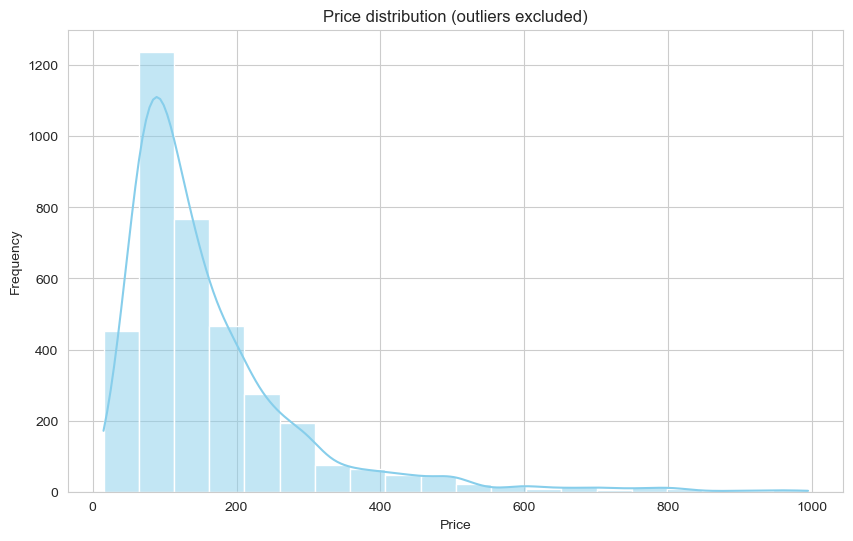

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram for values in the range 0 to 1000 
sns.histplot(listings_no_out['price'], kde=True, bins=20, color='skyblue', ax=ax)

# Customize labels and title
ax.set_xlabel('Price')
ax.set_ylabel('Frequency')
ax.set_title('Price distribution (outliers excluded)')

# Show the plot
plt.show()

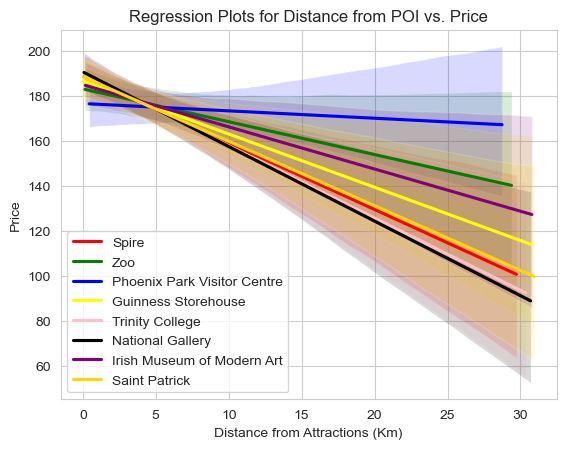

In [35]:
#regression plot for all distance features

sns.regplot(listings, x='Spire_distance', y='price', color='red', scatter=False, label='Spire')
sns.regplot(listings, x='zoo_distance', y='price', color='green', scatter=False, label='Zoo')
sns.regplot(listings, x='Phoenix park visitor centre_distance', y='price', color='blue', scatter=False, label='Phoenix Park Visitor Centre')
sns.regplot(listings, x='guinnes storehouse_distance', y='price', color='yellow', scatter=False, label="Guinness Storehouse")
sns.regplot(listings, x='trinity_distance', y='price', color='pink', scatter=False, label='Trinity College')
sns.regplot(listings, x='national gallery_distance', y='price', color='black', scatter=False, label='National Gallery')
sns.regplot(listings, x='Irish museum modern art_distance', y='price', color='purple', scatter=False, label='Irish Museum of Modern Art')
sns.regplot(listings, x='Saint patrick_distance', y='price', color='gold', scatter=False, label='Saint Patrick')

# Add title and labels
plt.title('Regression Plots for Distance from POI vs. Price')
plt.xlabel('Distance from Attractions (Km)')
plt.ylabel('Price')

# Add legend
plt.legend()

# Show the plot
plt.show()

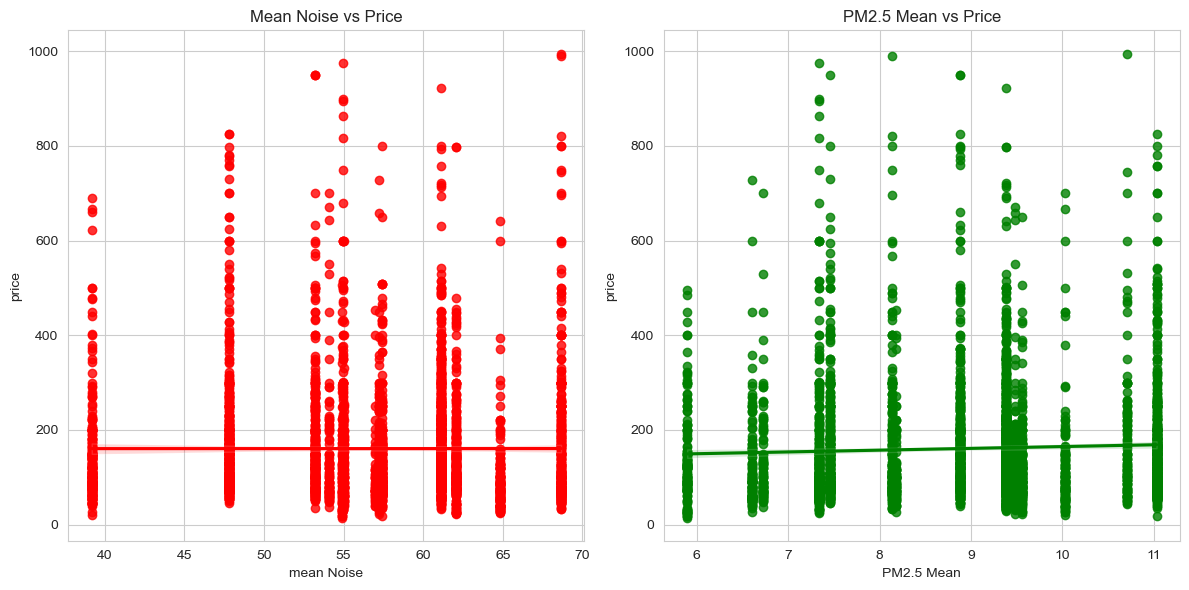

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Unpack the axes array
ax1, ax2 = axes.flatten()

# Plot the regression plots on each subplot
sns.regplot(listings_no_out,x='mean Noise',y='price',color='red',scatter=True, ax=ax1)
sns.regplot(listings_no_out,x='PM2.5 Mean',y='price',color='green',scatter=True, ax=ax2)

ax1.set_title('Mean Noise vs Price')
ax2.set_title('PM2.5 Mean vs Price')


# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

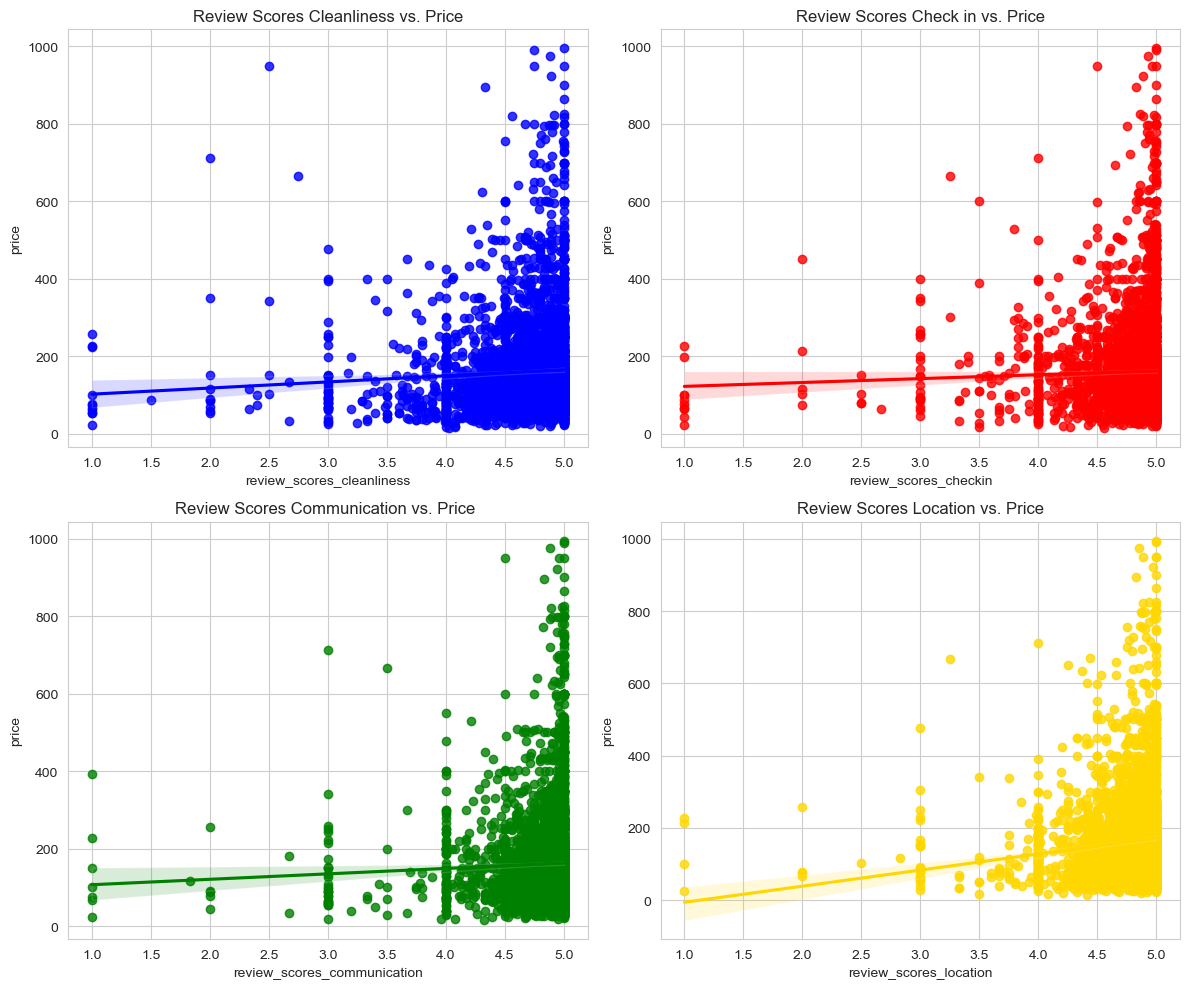

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Unpack the axes array
ax1, ax2, ax3, ax4 = axes.flatten()

# Plot the regression plots on each subplot
sns.regplot(listings_no_out, x='review_scores_cleanliness', y='price', color='blue', scatter=True, ax=ax1)
sns.regplot(listings_no_out, x='review_scores_checkin', y='price', color='red', scatter=True, ax=ax2)
sns.regplot(listings_no_out, x='review_scores_communication', y='price', color='green', scatter=True, ax=ax3)
sns.regplot(listings_no_out, x='review_scores_location', y='price', color='gold', scatter=True, ax=ax4)

ax1.set_title('Review Scores Cleanliness vs. Price')
ax2.set_title('Review Scores Check in vs. Price')
ax3.set_title('Review Scores Communication vs. Price ')
ax4.set_title('Review Scores Location vs. Price')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

In [38]:
#Correlations
all_columns_except_price = listings.columns.difference(['price'])

# Calculate the correlation
correlations = listings[all_columns_except_price].corrwith(listings_no_out['price'])
corr = pd.DataFrame(correlations.sort_values(ascending=False))
print(corr.to_string())

                                                     0
accommodates                                  0.685448
beds                                          0.530529
room_type_entire home/apt                     0.486828
Number of bathrooms                           0.462306
longitude_x                                   0.128504
PM10 min                                      0.119598
review_scores_location                        0.115824
host_since                                    0.087992
PM2.5 min                                     0.084825
host_response_time_within a day               0.076731
availability_365                              0.076528
review_scores_rating                          0.063860
last_review                                   0.063630
PM10 max                                      0.060175
PM10 Mean                                     0.060087
host_listings_count                           0.057618
review_scores_cleanliness                     0.056448
host_total

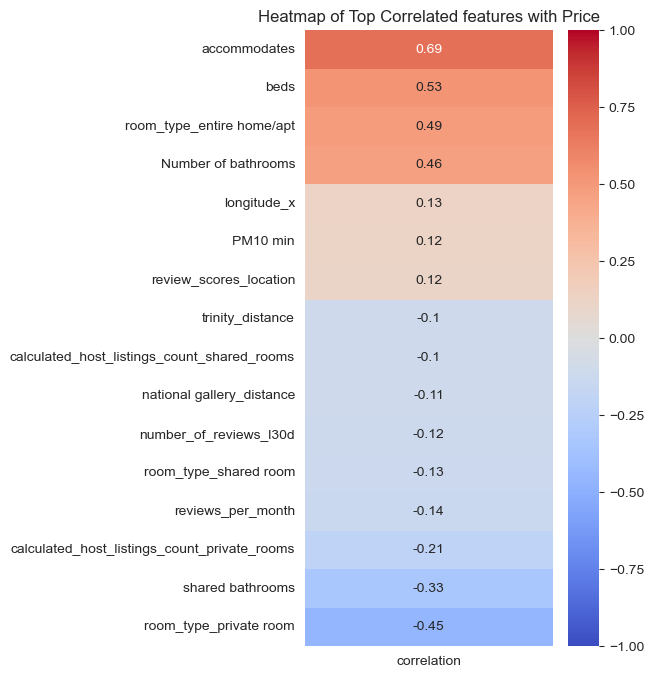

In [39]:
# Higher correlations
filtered_correlations = correlations[(correlations > 0.1) | (correlations < -0.1)]

# Sort correlations in descending order
sorted_correlations = filtered_correlations.sort_values(ascending=False)

# Reshape the sorted correlations into a DataFrame 
correlation_matrix = sorted_correlations.to_frame(name='correlation')

# Create heatmap
plt.figure(figsize=(4,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

#  plot title
plt.title('Heatmap of Top Correlated features with Price')
plt.show()

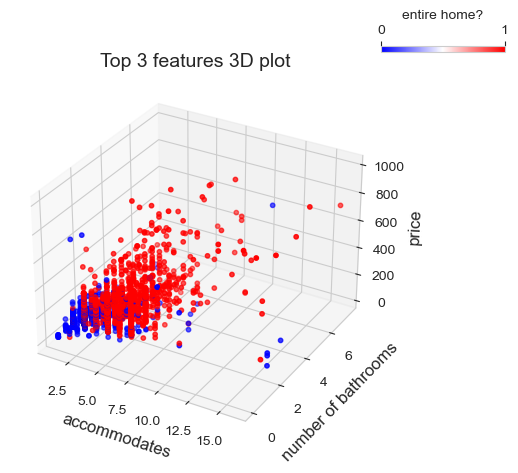

In [40]:
# 3D scatter plot 
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

#use the 4 most correlated features
a = listings[listings['price']<1000]
sc = ax.scatter(a['accommodates'], a['Number of bathrooms'], a['price'], c=a['room_type_entire home/apt'],cmap='bwr', marker='o',s=10)

# labels
ax.set_xlabel('accommodates',size=12)
ax.set_ylabel('number of bathrooms',size=12)
ax.set_zlabel('price',size=12)


# Add a colorbar to show the mapping of 'W' values
cbar = plt.colorbar(sc, shrink=0.2,location='top', anchor=(1.0, 1.0))  # Adjust the shrink parameter as needed
cbar.set_ticks([0, 1])
cbar.set_label('entire home?')
ax.set_title('Top 3 features 3D plot',size=14)
plt.show()

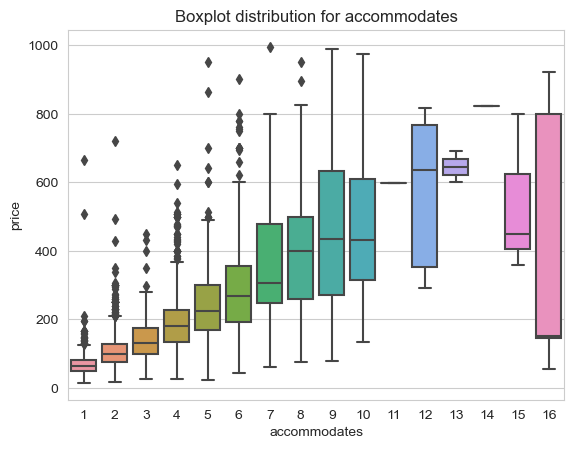

In [41]:
# plot accomodation and price boxplot
sns.boxplot(x='accommodates', y='price', data=listings_no_out)
plt.title('Boxplot distribution for accommodates')

# Show the plot
plt.show()

Text(0.5, 1.0, 'is listing entire apartment?')

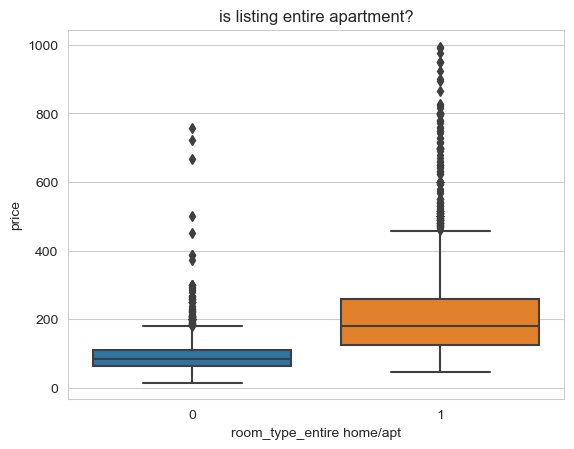

In [42]:
#boxplot for room type
sns.boxplot(x='room_type_entire home/apt', y='price', data=listings_no_out)
plt.title('is listing entire apartment?')

Text(0.5, 1.0, 'Scatterplot review score and price')

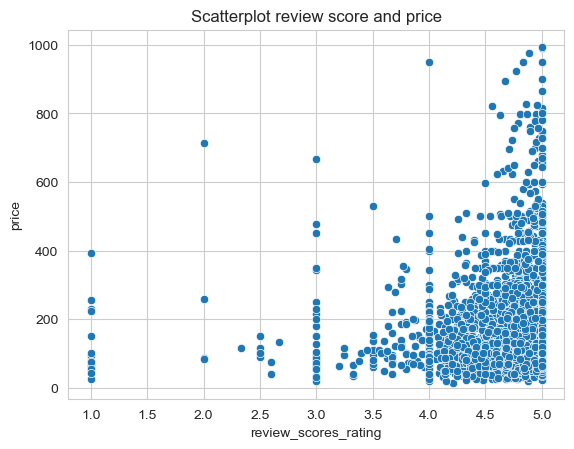

In [43]:
sns.scatterplot(x='review_scores_rating', y='price', data=listings_no_out)
plt.title('Scatterplot review score and price')

Text(0.5, 1.0, 'Mean Noise vs Price')

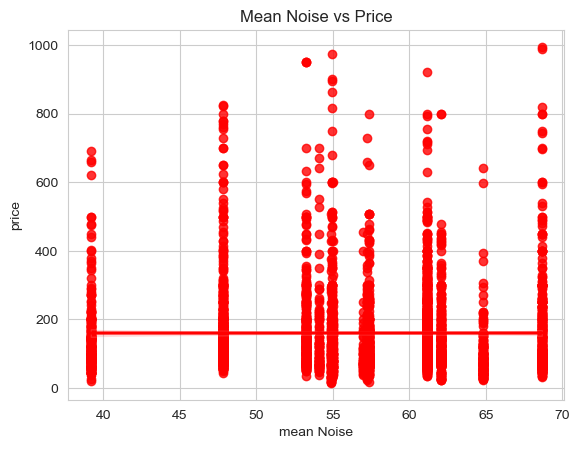

In [44]:
sns.regplot(listings_no_out,x='mean Noise',y='price',color='red',scatter=True)
plt.title('Mean Noise vs Price')

#### X - Y Split and scaling

In [45]:
X = listings.drop('price', axis=1)  # Features
y = listings['price']  # Target variable

# scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2, random_state=42)

In [46]:
#function for creating a dataset with scores from all models at the end

scoring = pd.DataFrame()

def Store_score(name, MAPE, r_squared):
    # Create dictionary 
    data = {'Name': [name], 'Mape': [MAPE], 'R squared': [r_squared]}
    
    #DataFrame
    new_row = pd.DataFrame(data)
    
    # Append the new row to the existing DataFrame
    global scoring 
    scoring= scoring.append(new_row, ignore_index=True)
    
    return scoring

    

#### Random Forest

In [47]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2'],
}

model = RandomForestRegressor(random_state=42)

# GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Store_score('Random Forest', MAPE, r_squared)
# Print R-squared value
print(f"\nR-squared: {r_squared}")
print(f"\nMAPE: {MAPE}")

c:\Users\santi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\santi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\santi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestR


R-squared: 0.7032560433461457

MAPE: 0.3378871584445134


C:\Users\santi\AppData\Local\Temp\ipykernel_27572\3238438088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring= scoring.append(new_row, ignore_index=True)


In [48]:
# feature importances
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
# sort
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature names and importance scores
for index, row in feature_importance_df.iterrows():
        print(f"Feature: {row['Feature']}, Importance: {row['Importance']}")


Feature: accommodates, Importance: 0.11226096918662751
Feature: calculated_host_listings_count_private_rooms, Importance: 0.1053644675978325
Feature: host_listings_count, Importance: 0.061596531890670984
Feature: beds, Importance: 0.05902068615818673
Feature: host_total_listings_count, Importance: 0.051628590189667097
Feature: last_review, Importance: 0.043222401261512014
Feature: Number of bathrooms, Importance: 0.03794656135487671
Feature: maximum_nights, Importance: 0.030468242810270232
Feature: calculated_host_listings_count, Importance: 0.025412978383763253
Feature: availability_365, Importance: 0.02388528512868619
Feature: reviews_per_month, Importance: 0.019372564747690373
Feature: room_type_entire home/apt, Importance: 0.019322657710101138
Feature: maximum_maximum_nights, Importance: 0.017844328140917024
Feature: minimum_maximum_nights, Importance: 0.017427142652582137
Feature: room_type_private room, Importance: 0.01687520582152556
Feature: national gallery_distance, Importanc

#### Linear regression

In [49]:
param_grid = {'fit_intercept': [True, False]}

linear_regressor = LinearRegression()

grid_search = GridSearchCV(estimator=linear_regressor, param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Fit the model 
best_model.fit(X_train, y_train)

# Get the coefficients (importances) of each feature
importances = best_model.coef_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by absolute importance in descending order
feature_importance_df['Importance'] = feature_importance_df['Importance'].abs()  # considering absolute values for coefficients
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature names and importance scores
for index, row in feature_importance_df.iterrows():
    print(f"Feature: {row['Feature']}, Importance: {row['Importance']}")


Feature: host_listings_count, Importance: 619.4884557982072
Feature: calculated_host_listings_count_entire_homes, Importance: 568.70736264578
Feature: calculated_host_listings_count, Importance: 549.7478900424387
Feature: host_total_listings_count, Importance: 539.44648849597
Feature: Irish museum modern art_distance, Importance: 332.1010472285684
Feature: Spire_distance, Importance: 268.55326277704665
Feature: var Noise, Importance: 260.3716253774226
Feature: trinity_distance, Importance: 246.349828765363
Feature: guinnes storehouse_distance, Importance: 245.41737720514163
Feature: var weekend Noise, Importance: 193.62247088749174
Feature: calculated_host_listings_count_private_rooms, Importance: 160.6500273273088
Feature: zoo_distance, Importance: 137.00839029958155
Feature: min Noise, Importance: 110.48898872780453
Feature: PM10 var, Importance: 82.02841305638032
Feature: Saint patrick_distance, Importance: 80.17952951487662
Feature: accommodates, Importance: 74.43519045738579
Featu

In [50]:
#predictions
y_pred = best_model.predict(X_test)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Store_score('Linear', MAPE, r_squared)

# Print R-squared value
print(f"\nR-squared: {r_squared}")
print(f"\nMAPE: {MAPE}")


R-squared: 0.5853417953656348

MAPE: 0.4853572377643279


C:\Users\santi\AppData\Local\Temp\ipykernel_27572\3238438088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring= scoring.append(new_row, ignore_index=True)


#### SVM

In [51]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 0.01, 0.001,1],
    'epsilon': [0.01, 0.1, 0.2,0.5],
    'gamma': ['scale', 'auto']
}

svm_regressor = SVR()

#  grid search 
grid_search = GridSearchCV(estimator=svm_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit 
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
r_squared = r2_score(y_test, y_pred)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Store_score('SVM', MAPE, r_squared)

# Print evaluation metrics
print(f"\nR-squared: {r_squared}")
print(f"\nMAPE: {MAPE}")


R-squared: 0.5938102515200455

MAPE: 0.33273187743845534


C:\Users\santi\AppData\Local\Temp\ipykernel_27572\3238438088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring= scoring.append(new_row, ignore_index=True)


#### Decision tree

In [52]:
# params
param_grid = {  
    'criterion': ['absolute_error', 'poisson', 'friedman_mse', 'squared_error'], 
    'max_depth': [100, 10],
    'splitter': ['best', 'random']
}

dt_regressor = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid,cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Store_score('Decision tree', MAPE, r_squared)

# Print R-squared value
print(f"\nR-squared: {r_squared}")
print(f"\nMAPE: {MAPE}")
print(grid_search.best_params_)


R-squared: 0.5084837576078385

MAPE: 0.35801060982846433
{'criterion': 'absolute_error', 'max_depth': 10, 'splitter': 'random'}


C:\Users\santi\AppData\Local\Temp\ipykernel_27572\3238438088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring= scoring.append(new_row, ignore_index=True)


#### Neural Networks

In [53]:
#Best architecture after testing was using leaky Relu

model = Sequential()
model.add(Dense(78, input_dim=78, activation='leaky_relu'))
model.add(Dense(156, activation='leaky_relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.fit(X_scaled, y, epochs=100, batch_size=32, validation_split=0.2)
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss}')
y_pred = model.predict(X_test)
r_squared = r2_score(y_test, y_pred)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Store_score('Neural network', MAPE, r_squared)
print(f"\nR-squared 2: {r_squared}")
print(f"\nMAPE 2: {MAPE}")


tensorflow WARNING From c:\Users\santi\anaconda3\lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



tensorflow WARNING From c:\Users\santi\anaconda3\lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Epoch 1/100



tensorflow WARNING From c:\Users\santi\anaconda3\lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.



94/94 [==============================] - 1s 3ms/step - loss: 78609.9062 - val_loss: 13537.0742
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 46646.6914 - val_loss: 6162.0332
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 38981.7344 - val_loss: 6357.9209
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 36600.7930 - val_loss: 6447.2998
Epoch 5/100
94/94 [==============================] - 0s 1ms/step - loss: 35771.9531 - val_loss: 6386.7915
Epoch 6/100
94/94 [==============================] - 0s 1ms/step - loss: 35639.6094 - val_loss: 6335.7119
Epoch 7/100
94/94 [==============================] - 0s 1ms/step - loss: 35408.2891 - val_loss: 6264.8867
Epoch 8/100
94/94 [==============================] - 0s 1ms/step - loss: 35219.6133 - val_loss: 6256.5679
Epoch 9/100
94/94 [==============================] - 0s 1ms/step - loss: 34982.8672 - val_loss: 6301.6250
Epoch 10/100
94/94 [==============================] - 0s 

C:\Users\santi\AppData\Local\Temp\ipykernel_27572\3238438088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scoring= scoring.append(new_row, ignore_index=True)


## Noise sensor time seires

Text(0.5, 1.0, 'Drumcondra library readings (15 Nov-15 Dec)')

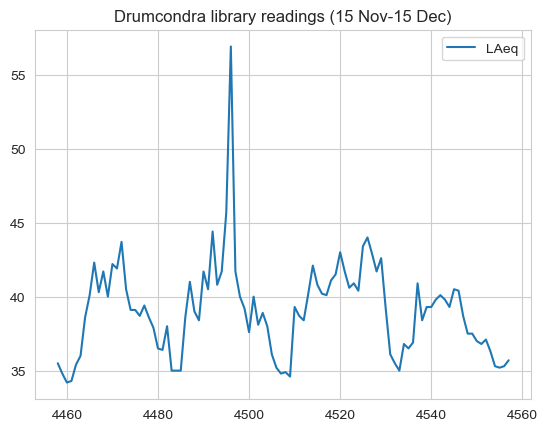

In [54]:
#time series using Drumcondra_library sensor
Test = Noise[Noise['sensor']=="Drumcondra_library"]

sns.lineplot(Test[:100])
plt.title('Drumcondra library readings (15 Nov-15 Dec)')

In [55]:
from statsmodels.tsa.stattools import adfuller
adfuller(Test['LAeq'])
#P value is 0.0011149735567474947, series is stationary

(-4.062834029618299,
 0.0011149735567474947,
 20,
 722,
 {'1%': -3.439439614524914,
  '5%': -2.865551414233055,
  '10%': -2.5689061365397747},
 3139.873340789173)

c:\Users\santi\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


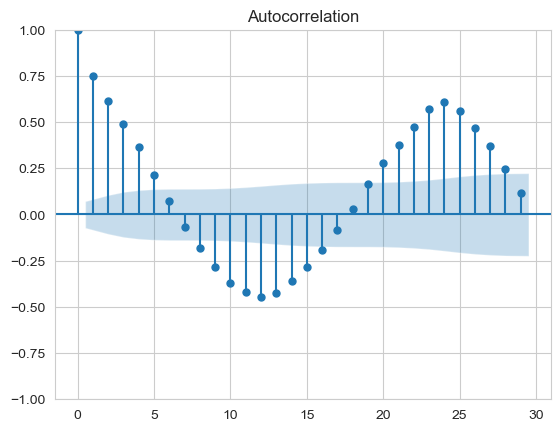

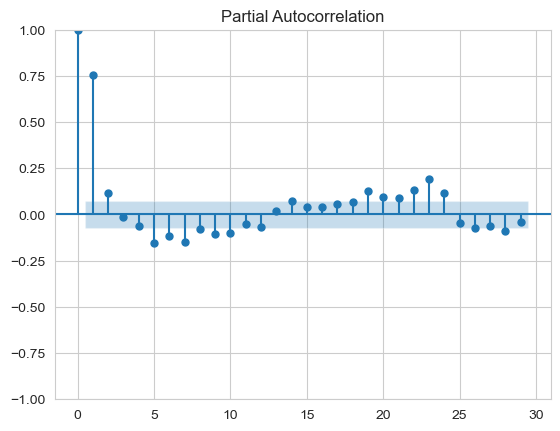

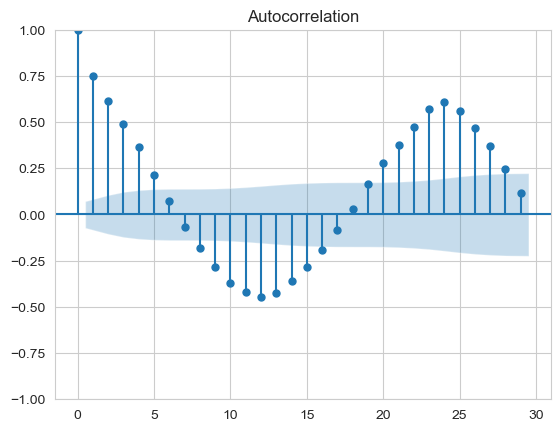

In [56]:
#autocorrelation and partial correlation
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_pacf(Test['LAeq'])
plot_acf(Test['LAeq'])

In [57]:
# Convert 'Date and Time' column to datetime
Test['Date and Time'] = pd.to_datetime(Test['Date and Time'])

# Extract weekday and scale it
Test['hour'] = Test['Date and Time'].dt.hour 
Test['Day of'] = Test['Date and Time'].dt.dayofweek +1
Test.set_index('Date and Time', inplace=True)
Test = Test.asfreq(freq ='H')
Test['Rol mean 24'] = Test['LAeq'].rolling(window=24, closed='right').mean()
Test['Rol mean 168'] = Test['LAeq'].rolling(window=168, closed='right').mean()
Test= Test[['Day of','LAeq', 'Rol mean 24' ,'Rol mean 168','hour']]


C:\Users\santi\AppData\Local\Temp\ipykernel_27572\1867424753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Date and Time'] = pd.to_datetime(Test['Date and Time'])
C:\Users\santi\AppData\Local\Temp\ipykernel_27572\1867424753.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['hour'] = Test['Date and Time'].dt.hour
C:\Users\santi\AppData\Local\Temp\ipykernel_27572\1867424753.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

Text(0.5, 1.0, 'Boxplot for hour of the day')

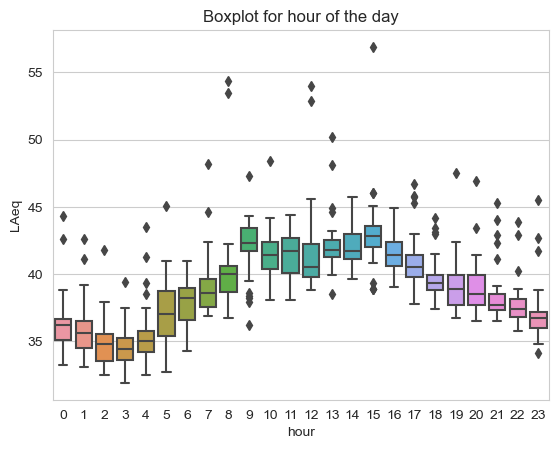

In [58]:
sns.boxplot(data=Test,x='hour',y='LAeq')
plt.title('Boxplot for hour of the day')

In [59]:
# Split the dataset into training and testing (80% train, 20% test)
train, test = Test[:len(Test)-168], Test[len(Test)-168:]

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2', None],
}

lags_grid = [7, 24, [1,2,3,4,5,6,7,22,23,24,25,26]]

# Create and fit the forecaster
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=7
)
forecaster.fit(y=train["LAeq"], exog=train['hour'])

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = train["LAeq"],
                        exog        = train['hour'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        allow_incomplete_fold = False,
                        initial_train_size    = int(len(train["LAeq"])*0.5),
                        return_best = True,
                        verbose     = False
                )

#print best parameters
results_grid.iloc[0]['params']

Number of models compared: 1944.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/648 [00:00<?, ?it/s]

c:\Users\santi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\santi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\santi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestR

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
  Backtesting metric: 4.180353778368404



{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 10}

In [60]:
results_grid

,lags,params,mean_squared_error,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
282,"[1, 2, 3, 4, 5, 6, 7]","{'bootstrap': True, 'max_depth': 20, 'max_feat...",4.180354,True,20.0,log2,2,5,10
66,"[1, 2, 3, 4, 5, 6, 7]","{'bootstrap': True, 'max_depth': None, 'max_fe...",4.180354,True,NaN,log2,2,5,10
396,"[1, 2, 3, 4, 5, 6, 7]","{'bootstrap': False, 'max_depth': None, 'max_f...",4.279432,False,NaN,log2,4,2,10
399,"[1, 2, 3, 4, 5, 6, 7]","{'bootstrap': False, 'max_depth': None, 'max_f...",4.279432,False,NaN,log2,4,5,10
615,"[1, 2, 3, 4, 5, 6, 7]","{'bootstrap': False, 'max_depth': 20, 'max_fea...",4.279432,False,20.0,log2,4,5,10
...,...,...,...,...,...,...,...,...,...
1380,"[1, 2, 3, 4, 5, 6, 7, 22, 23, 24, 25, 26]","{'bootstrap': True, 'max_depth': None, 'max_fe...",14.578456,True,NaN,None,1,5,10
1596,"[1, 2, 3, 4, 5, 6, 7, 22, 23, 24, 25, 26]","{'bootstrap': True, 'max_depth': 20, 'max_feat...",14.578456,True,20.0,None,1,5,10
1299,"[1, 2, 3, 4, 5, 6, 7, 22, 23, 24, 25, 26]","{'bootstrap': True, 'max_depth': None, 'max_fe...",14.578456,True,NaN,auto,1,5,10
1407,"[1, 2, 3, 4, 5, 6, 7, 22, 23, 24, 25, 26]","{'bootstrap': True, 'max_depth': 10, 'max_feat...",15.255884,True,10.0,auto,1,5,10


Text(0.5, 1.0, 'Actual vs predictions Drumcondra library')

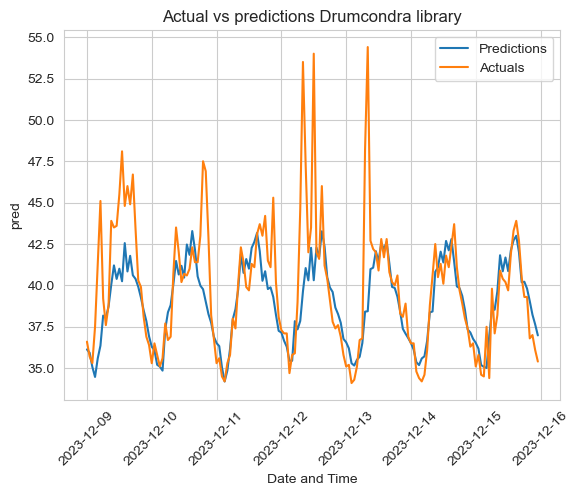

In [61]:
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123,
                                    bootstrap = False,
                                    max_depth= 20,
                                    max_features= 'log2',
                                    min_samples_leaf= 2,
                                    min_samples_split= 5,
                                    n_estimators= 50),
    lags=7
)
forecaster.fit(y=train["LAeq"], exog=train['hour'])
predictions = forecaster.predict(steps=168, exog=test['hour'])

sns.lineplot(predictions, label='Predictions')
sns.lineplot(test['LAeq'],label='Actuals')
plt.xticks(rotation=45)
plt.title('Actual vs predictions Drumcondra library')


In [62]:
results_grid.iloc[0]

lags                                              [1, 2, 3, 4, 5, 6, 7]
params                {'bootstrap': True, 'max_depth': 20, 'max_feat...
mean_squared_error                                             4.180354
bootstrap                                                          True
max_depth                                                          20.0
max_features                                                       log2
min_samples_leaf                                                      2
min_samples_split                                                     5
n_estimators                                                         10
Name: 282, dtype: object

In [63]:
date_range = pd.date_range(start='2023-12-16 00:00:00', periods=24*7, freq='H')

# Create a DataFrame with the date range as the index
df = pd.DataFrame(index=date_range,)
df['hour'] = df.index.hour


forecaster.fit(y=Test["LAeq"], exog=Test['hour'])

# Make predictions for 168 steps (assuming hourly data and predicting 7 days ahead)
predictions = forecaster.predict(steps=168, exog=df['hour'])

In [64]:
len(Test["LAeq"].values)

743

<AxesSubplot:ylabel='0'>

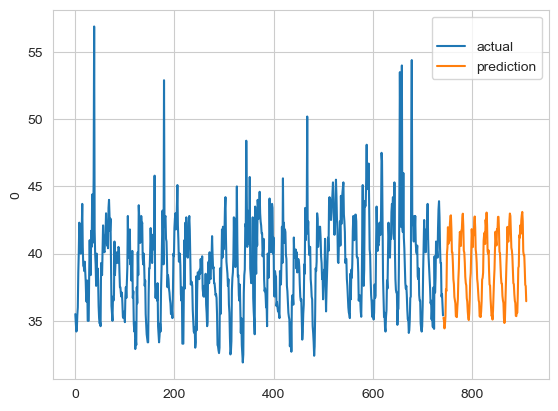

In [65]:
a = Test["LAeq"].values
plott = np.append(a,predictions.values)
plott = pd.DataFrame(plott)

#create column for pred/actual
plott[' '] = 'actual'
plott.loc[len(Test["LAeq"].values):, ' '] = 'prediction'

sns.lineplot(data=plott, x=plott.index, y=0, hue=' ')

#### Scoring

In [66]:
scoring

,Name,Mape,R squared
0,Random Forest,0.337887,0.703256
1,Linear,0.485357,0.585342
2,SVM,0.332732,0.593810
3,Decision tree,0.358011,0.508484
4,Neural network,0.354621,0.799585
